<a href="https://colab.research.google.com/github/flahbocchino/hermes-reply-fase5/blob/main/HermesReply_Fase5_DB%2BML_FlaviaePedro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
%pip install -q pandas scikit-learn matplotlib SQLAlchemy==2.0.30 eralchemy2
!apt-get -y -qq update
!apt-get -y -qq install graphviz


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [89]:
%pip install -q pandas scikit-learn matplotlib SQLAlchemy==2.0.30 sqlalchemy_schemadisplay pydot
!apt-get -y -qq update
!apt-get -y -qq install graphviz


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [90]:
# Ver se o binário do Graphviz está ok
!dot -V

# Imports
import os, sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Para gerar o DER (sem pygraphviz)
from sqlalchemy import create_engine, MetaData
from sqlalchemy_schemadisplay import create_schema_graph

print("Imports OK.")


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
dot - graphviz version 2.43.0 (0)
Imports OK.


In [91]:
# CÉLULA CORRIGIDA — CRIAR A ESTRUTURA DO PROJETO (robusta)

from pathlib import Path
import os

# garanta que estamos no /content (diretório padrão do Colab)
os.chdir("/content")

ROOT = Path("/content/hermes-reply-fase5")
SUBS = ["data", "ddl", "images", "notebooks", "src"]

# cria pasta raiz e subpastas
ROOT.mkdir(parents=True, exist_ok=True)
for s in SUBS:
    (ROOT / s).mkdir(parents=True, exist_ok=True)

print("✅ Estrutura criada em:", ROOT)

# mostrar a árvore (2 níveis) para conferir
!find /content/hermes-reply-fase5 -maxdepth 2 -type d | sort



✅ Estrutura criada em: /content/hermes-reply-fase5
/content/hermes-reply-fase5
/content/hermes-reply-fase5/data
/content/hermes-reply-fase5/ddl
/content/hermes-reply-fase5/images
/content/hermes-reply-fase5/notebooks
/content/hermes-reply-fase5/reports
/content/hermes-reply-fase5/src


In [92]:
# CÉLULA 2 (limpa e final) — grava e pré-visualiza o schema.sql, e lista a pasta

import os

PROJECT = "hermes-reply-fase5"
os.makedirs(os.path.join(PROJECT, "ddl"), exist_ok=True)
ddl_path = os.path.join(PROJECT, "ddl", "schema.sql")

schema_sql = """
PRAGMA foreign_keys = ON;

CREATE TABLE IF NOT EXISTS sites (
    site_id      INTEGER PRIMARY KEY,
    name         TEXT NOT NULL,
    city         TEXT,
    state        TEXT,
    country      TEXT
);

CREATE TABLE IF NOT EXISTS assets (
    asset_id      INTEGER PRIMARY KEY,
    site_id       INTEGER NOT NULL,
    name          TEXT NOT NULL,
    asset_type    TEXT NOT NULL,
    manufacturer  TEXT,
    model         TEXT,
    install_date  DATE,
    serial_number TEXT UNIQUE,
    FOREIGN KEY (site_id) REFERENCES sites(site_id) ON DELETE CASCADE
);

CREATE TABLE IF NOT EXISTS sensor_types (
    sensor_type_id INTEGER PRIMARY KEY,
    name           TEXT UNIQUE NOT NULL,
    description    TEXT
);

CREATE TABLE IF NOT EXISTS units (
    unit_id INTEGER PRIMARY KEY,
    symbol  TEXT UNIQUE NOT NULL,
    name    TEXT NOT NULL
);

CREATE TABLE IF NOT EXISTS sensors (
    sensor_id        INTEGER PRIMARY KEY,
    asset_id         INTEGER NOT NULL,
    sensor_type_id   INTEGER NOT NULL,
    unit_id          INTEGER NOT NULL,
    serial_number    TEXT UNIQUE,
    sampling_rate_hz REAL CHECK (sampling_rate_hz > 0),
    min_value        REAL,
    max_value        REAL,
    calibration_date DATE,
    status           TEXT NOT NULL DEFAULT 'active' CHECK (status IN ('active','inactive','maintenance')),
    FOREIGN KEY (asset_id)       REFERENCES assets(asset_id)       ON DELETE CASCADE,
    FOREIGN KEY (sensor_type_id) REFERENCES sensor_types(sensor_type_id),
    FOREIGN KEY (unit_id)        REFERENCES units(unit_id)
);

CREATE TABLE IF NOT EXISTS thresholds (
    threshold_id INTEGER PRIMARY KEY,
    sensor_id    INTEGER UNIQUE NOT NULL,
    lower_warn   REAL,
    upper_warn   REAL,
    lower_crit   REAL,
    upper_crit   REAL,
    FOREIGN KEY (sensor_id) REFERENCES sensors(sensor_id) ON DELETE CASCADE,
    CHECK ((lower_warn IS NULL OR upper_warn IS NULL) OR (lower_warn < upper_warn)),
    CHECK ((lower_crit IS NULL OR upper_crit IS NULL) OR (lower_crit < upper_crit))
);

CREATE TABLE IF NOT EXISTS readings (
    sensor_id    INTEGER NOT NULL,
    ts           DATETIME NOT NULL,
    value        REAL NOT NULL,
    quality_flag TEXT DEFAULT 'ok' CHECK (quality_flag IN ('ok','suspect','bad')),
    PRIMARY KEY (sensor_id, ts),
    FOREIGN KEY (sensor_id) REFERENCES sensors(sensor_id) ON DELETE CASCADE
);

CREATE TABLE IF NOT EXISTS alerts (
    alert_id       INTEGER PRIMARY KEY,
    sensor_id      INTEGER NOT NULL,
    ts             DATETIME NOT NULL,
    alert_level    TEXT NOT NULL CHECK (alert_level IN ('WARN','CRIT')),
    measured_value REAL NOT NULL,
    resolved_flag  INTEGER NOT NULL DEFAULT 0,
    FOREIGN KEY (sensor_id) REFERENCES sensors(sensor_id)
);

CREATE TABLE IF NOT EXISTS maintenance_events (
    event_id   INTEGER PRIMARY KEY,
    asset_id   INTEGER NOT NULL,
    start_ts   DATETIME NOT NULL,
    end_ts     DATETIME,
    event_type TEXT NOT NULL CHECK (event_type IN ('scheduled','unscheduled','inspection','repair')),
    description TEXT,
    FOREIGN KEY (asset_id) REFERENCES assets(asset_id)
);

CREATE INDEX IF NOT EXISTS idx_readings_ts ON readings(ts);
CREATE INDEX IF NOT EXISTS idx_readings_sensor_ts ON readings(sensor_id, ts DESC);
""".strip()

# 1) gravar
with open(ddl_path, "w", encoding="utf-8") as f:
    f.write(schema_sql + "\n")

print("✅ schema.sql criado em:", ddl_path)

# 2) prévia (primeiras ~60 linhas)
with open(ddl_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
for i, line in enumerate(lines[:60], start=1):
    print(f"{i:02d}: {line.rstrip()}")
if len(lines) > 60:
    print("... (arquivo continua)")

# 3) listar a pasta
print("\nConteúdo de hermes-reply-fase5/ddl:")
for root, dirs, files in os.walk(os.path.join(PROJECT, "ddl")):
    for fn in files:
        print(" -", os.path.join(root, fn))


✅ schema.sql criado em: hermes-reply-fase5/ddl/schema.sql
01: PRAGMA foreign_keys = ON;
02: 
03: CREATE TABLE IF NOT EXISTS sites (
04:     site_id      INTEGER PRIMARY KEY,
05:     name         TEXT NOT NULL,
06:     city         TEXT,
07:     state        TEXT,
08:     country      TEXT
09: );
10: 
11: CREATE TABLE IF NOT EXISTS assets (
12:     asset_id      INTEGER PRIMARY KEY,
13:     site_id       INTEGER NOT NULL,
14:     name          TEXT NOT NULL,
15:     asset_type    TEXT NOT NULL,
16:     manufacturer  TEXT,
17:     model         TEXT,
18:     install_date  DATE,
19:     serial_number TEXT UNIQUE,
20:     FOREIGN KEY (site_id) REFERENCES sites(site_id) ON DELETE CASCADE
21: );
22: 
23: CREATE TABLE IF NOT EXISTS sensor_types (
24:     sensor_type_id INTEGER PRIMARY KEY,
25:     name           TEXT UNIQUE NOT NULL,
26:     description    TEXT
27: );
28: 
29: CREATE TABLE IF NOT EXISTS units (
30:     unit_id INTEGER PRIMARY KEY,
31:     symbol  TEXT UNIQUE NOT NULL,
32:    

In [93]:
# CÉLULA 3A — checagem e setup
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# garanta que a pasta do projeto exista (redefine PROJECT aqui)
PROJECT = "hermes-reply-fase5"
for sub in ["", "data"]:
    os.makedirs(os.path.join(PROJECT, sub), exist_ok=True)

print("OK: pandas", pd.__version__)
print("OK: pasta existe:", os.path.isdir(PROJECT), "->", PROJECT)
print("OK: subpasta data existe:", os.path.isdir(os.path.join(PROJECT, "data")))


OK: pandas 2.2.2
OK: pasta existe: True -> hermes-reply-fase5
OK: subpasta data existe: True


In [94]:
# CÉLULA 3B — gerar CSVs (com tratamento de erros e tudo auto-contido)

import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

try:
    # ---------- Tabelas básicas ----------
    sites = pd.DataFrame([
        {"site_id": 1, "name": "Plant A", "city": "São Paulo", "state": "SP", "country": "BR"},
        {"site_id": 2, "name": "Plant B", "city": "Campinas", "state": "SP", "country": "BR"},
    ])

    assets = pd.DataFrame([
        {"asset_id": 1, "site_id": 1, "name": "Compressor-01", "asset_type": "compressor", "manufacturer": "ACME", "model": "C1000", "install_date": "2023-01-15", "serial_number": "CMP-001"},
        {"asset_id": 2, "site_id": 1, "name": "Motor-01",      "asset_type": "motor",      "manufacturer": "ACME", "model": "M500",  "install_date": "2023-01-15", "serial_number": "MTR-001"},
        {"asset_id": 3, "site_id": 2, "name": "Turbine-01",    "asset_type": "turbine",    "manufacturer": "ACME", "model": "T300",  "install_date": "2023-02-10", "serial_number": "TRB-001"},
        {"asset_id": 4, "site_id": 2, "name": "Pump-01",       "asset_type": "pump",       "manufacturer": "ACME", "model": "P200",  "install_date": "2023-02-10", "serial_number": "PMP-001"},
        {"asset_id": 5, "site_id": 1, "name": "Fan-01",        "asset_type": "fan",        "manufacturer": "ACME", "model": "F150",  "install_date": "2023-03-05", "serial_number": "FAN-001"},
    ])

    sensor_types = pd.DataFrame([
        {"sensor_type_id": 1, "name": "temperature", "description": "Process temperature"},
        {"sensor_type_id": 2, "name": "vibration",   "description": "Vibration velocity"},
        {"sensor_type_id": 3, "name": "current",     "description": "Motor electrical current"},
    ])

    units = pd.DataFrame([
        {"unit_id": 1, "symbol": "°C", "name": "degree Celsius"},
        {"unit_id": 2, "symbol": "mm/s", "name": "millimeters per second"},
        {"unit_id": 3, "symbol": "A", "name": "ampere"},
    ])

    # ---------- Sensores ----------
    sensors_list = []
    sid = 1
    for _, a in assets.iterrows():
        sensors_list.append({"sensor_id": sid, "asset_id": a.asset_id, "sensor_type_id": 1, "unit_id": 1, "serial_number": f"TEMP-{a.asset_id:03d}", "sampling_rate_hz": 1.0, "min_value": -20, "max_value": 120, "calibration_date": "2024-01-01", "status": "active"}); sid += 1
        sensors_list.append({"sensor_id": sid, "asset_id": a.asset_id, "sensor_type_id": 2, "unit_id": 2, "serial_number": f"VIB-{a.asset_id:03d}",  "sampling_rate_hz": 1.0, "min_value": 0,   "max_value": 20,  "calibration_date": "2024-01-01", "status": "active"}); sid += 1
        sensors_list.append({"sensor_id": sid, "asset_id": a.asset_id, "sensor_type_id": 3, "unit_id": 3, "serial_number": f"CUR-{a.asset_id:03d}",  "sampling_rate_hz": 1.0, "min_value": 0,   "max_value": 30,  "calibration_date": "2024-01-01", "status": "active"}); sid += 1
    sensors_df = pd.DataFrame(sensors_list)

    # ---------- Thresholds ----------
    thresholds_list = []
    for _, s in sensors_df.iterrows():
        if s.sensor_type_id == 1:
            thresholds_list.append({"threshold_id": s.sensor_id, "sensor_id": s.sensor_id, "lower_warn": None, "upper_warn": 75, "lower_crit": None, "upper_crit": 90})
        elif s.sensor_type_id == 2:
            thresholds_list.append({"threshold_id": s.sensor_id, "sensor_id": s.sensor_id, "lower_warn": None, "upper_warn": 6,  "lower_crit": None, "upper_crit": 10})
        else:
            thresholds_list.append({"threshold_id": s.sensor_id, "sensor_id": s.sensor_id, "lower_warn": None, "upper_warn": 12, "lower_crit": None, "upper_crit": 18})
    thresholds_df = pd.DataFrame(thresholds_list)

    # ---------- Readings (600 por sensor) ----------
    np.random.seed(7)
    start = datetime(2025, 8, 1, 8, 0, 0)
    minutes = 600
    timestamps = [start + timedelta(minutes=i) for i in range(minutes)]

    rows = []
    for _, s in sensors_df.iterrows():
        if s.sensor_type_id == 1:
            base = 65 + 5*np.sin(np.linspace(0, 6*np.pi, minutes))
            noise = np.random.normal(0, 1.5, size=minutes)
            values = base + noise
        elif s.sensor_type_id == 2:
            base = 4 + np.abs(np.random.normal(0, 0.8, size=minutes))
            values = base
        else:
            base = 9 + np.random.normal(0, 0.7, size=minutes)
            values = base

        for ts, val in zip(timestamps, values):
            rows.append({
                "sensor_id": int(s.sensor_id),
                "ts": ts.strftime("%Y-%m-%d %H:%M:%S"),
                "value": float(np.round(val, 3)),
                "quality_flag": "ok"
            })

    readings_df = pd.DataFrame(rows)

    # ---------- salvar ----------
    paths = {
        "sites": os.path.join(PROJECT, "data", "sites.csv"),
        "assets": os.path.join(PROJECT, "data", "assets.csv"),
        "sensor_types": os.path.join(PROJECT, "data", "sensor_types.csv"),
        "units": os.path.join(PROJECT, "data", "units.csv"),
        "sensors": os.path.join(PROJECT, "data", "sensors.csv"),
        "thresholds": os.path.join(PROJECT, "data", "thresholds.csv"),
        "readings": os.path.join(PROJECT, "data", "readings.csv"),
    }
    sites.to_csv(paths["sites"], index=False)
    assets.to_csv(paths["assets"], index=False)
    sensor_types.to_csv(paths["sensor_types"], index=False)
    units.to_csv(paths["units"], index=False)
    sensors_df.to_csv(paths["sensors"], index=False)
    thresholds_df.to_csv(paths["thresholds"], index=False)
    readings_df.to_csv(paths["readings"], index=False)

    print("✅ CSVs criados em:", os.path.join(PROJECT, "data"))
    print("Contagens -> sites:", len(sites),
          "| assets:", len(assets),
          "| sensors:", len(sensors_df),
          "| readings:", len(readings_df))

except Exception as e:
    import traceback
    print("❌ Erro ao gerar CSVs:", e)
    print(traceback.format_exc())


✅ CSVs criados em: hermes-reply-fase5/data
Contagens -> sites: 2 | assets: 5 | sensors: 15 | readings: 9000


In [95]:
# RECRIAR ESTRUTURA DO PROJETO (robusta)
from pathlib import Path

BASE = Path("/content")
ROOT = BASE / "hermes-reply-fase5"         # pasta do projeto
SUBS = ["data", "ddl", "images", "notebooks", "src"]

# cria a pasta raiz e as subpastas
ROOT.mkdir(parents=True, exist_ok=True)
for s in SUBS:
    (ROOT / s).mkdir(parents=True, exist_ok=True)

print("✅ Estrutura criada em:", ROOT)
!ls -R {ROOT}


✅ Estrutura criada em: /content/hermes-reply-fase5
/content/hermes-reply-fase5:
data  ddl  images  notebooks  README.md  reports  sensors.db  src

/content/hermes-reply-fase5/data:
assets.csv    sensors.csv	sites.csv	units.csv
readings.csv  sensor_types.csv	thresholds.csv

/content/hermes-reply-fase5/ddl:
schema.sql

/content/hermes-reply-fase5/images:
confusion_matrix_from_script.png  er_diagram.png	 serie_sensor_1.png
confusion_matrix.png		  leituras_por_tipo.png

/content/hermes-reply-fase5/notebooks:

/content/hermes-reply-fase5/reports:
train_log.txt

/content/hermes-reply-fase5/src:
train_ml.py


In [96]:
import os, sqlite3
import pandas as pd
from IPython.display import display

PROJECT = "hermes-reply-fase5"
DB_PATH = os.path.join(PROJECT, "sensors.db")
DDL_PATH = os.path.join(PROJECT, "ddl", "schema.sql")

# 0) Se existir um DB antigo, apaga para evitar duplicidades/erros de PK/UNIQUE
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)
    print("🧹 DB antigo removido:", DB_PATH)

# 1) Criar DB novo
con = sqlite3.connect(DB_PATH)
con.execute("PRAGMA foreign_keys = ON;")

# 2) Aplicar DDL (criar tabelas, FKs, índices)
with open(DDL_PATH, "r", encoding="utf-8") as f:
    con.executescript(f.read())
con.commit()
print("✅ Schema aplicado.")

# 3) Importar CSVs na ordem correta (referências -> fatos)
paths = {
    "sites":        os.path.join(PROJECT, "data", "sites.csv"),
    "assets":       os.path.join(PROJECT, "data", "assets.csv"),
    "sensor_types": os.path.join(PROJECT, "data", "sensor_types.csv"),
    "units":        os.path.join(PROJECT, "data", "units.csv"),
    "sensors":      os.path.join(PROJECT, "data", "sensors.csv"),
    "thresholds":   os.path.join(PROJECT, "data", "thresholds.csv"),
    "readings":     os.path.join(PROJECT, "data", "readings.csv"),
}

for table, path in paths.items():
    df = pd.read_csv(path)
    # usamos append porque as tabelas já existem com restrições
    df.to_sql(table, con, if_exists="append", index=False)
    print(f"OK -> {table}: {len(df)} linhas")

# 4) Validação rápida
q = """
SELECT a.asset_id, a.name AS asset_name, COUNT(r.ts) AS leituras
FROM assets a
JOIN sensors s ON s.asset_id = a.asset_id
JOIN readings r ON r.sensor_id = s.sensor_id
GROUP BY a.asset_id, a.name
ORDER BY a.asset_id;
"""
display(pd.read_sql(q, con))

print("🎉 Banco pronto em:", DB_PATH)


🧹 DB antigo removido: hermes-reply-fase5/sensors.db
✅ Schema aplicado.
OK -> sites: 2 linhas
OK -> assets: 5 linhas
OK -> sensor_types: 3 linhas
OK -> units: 3 linhas
OK -> sensors: 15 linhas
OK -> thresholds: 15 linhas
OK -> readings: 9000 linhas


,asset_id,asset_name,leituras
0,1,Compressor-01,1800
1,2,Motor-01,1800
2,3,Turbine-01,1800
3,4,Pump-01,1800
4,5,Fan-01,1800


🎉 Banco pronto em: hermes-reply-fase5/sensors.db


In [97]:
from sqlalchemy import create_engine, MetaData
from sqlalchemy_schemadisplay import create_schema_graph
import os

PROJECT = "hermes-reply-fase5"
DB_PATH = os.path.join(PROJECT, "sensors.db")
IMG_PATH = os.path.join(PROJECT, "images", "er_diagram.png")

# cria engine para o banco SQLite
engine = create_engine(f"sqlite:///{DB_PATH}")
metadata = MetaData()
metadata.reflect(bind=engine)

graph = create_schema_graph(
    engine=engine,          # <-- obrigatório nesta versão
    metadata=metadata,
    show_datatypes=False,
    show_indexes=False,
    rankdir='LR',
    concentrate=False
)

graph.write_png(IMG_PATH)
print("✅ DER salvo em:", IMG_PATH)


✅ DER salvo em: hermes-reply-fase5/images/er_diagram.png


In [98]:
import pandas as pd
import numpy as np

# carregar tabelas necessárias
readings = pd.read_sql("SELECT * FROM readings;", con)
sensors   = pd.read_sql("SELECT sensor_id, asset_id, sensor_type_id FROM sensors;", con)
types_    = pd.read_sql("SELECT sensor_type_id, name FROM sensor_types;", con)

# juntar e ordenar
df = readings.merge(sensors, on="sensor_id").merge(types_, on="sensor_type_id")
df["ts"] = pd.to_datetime(df["ts"])
df = df.sort_values(["asset_id","ts"])

# pivotar -> cada linha = asset+tempo, colunas = temperature/vibration/current
wide = (df.pivot_table(index=["asset_id","ts"], columns="name", values="value")
          .reset_index()
          .dropna()
          .sort_values(["asset_id","ts"]))

# criar lags (valor anterior de cada sensor)
for col in ["temperature","vibration","current"]:
    wide[col+"_lag1"] = wide.groupby("asset_id")[col].shift(1)

wide = wide.dropna()

# criar rótulo needs_maintenance (simulado)
wide["needs_maintenance"] = (
    (wide["temperature"] > 80) &
    (wide["vibration"]   > 8)  &
    (wide["current"]     > 15)
).astype(int)

# adicionar 5% de ruído (para simular falhas)
rng = np.random.default_rng(42)
flip = rng.choice(wide.index, size=int(0.05*len(wide)), replace=False)
wide.loc[flip, "needs_maintenance"] = 1 - wide.loc[flip, "needs_maintenance"]

print("✅ Dataset preparado")
wide.head()


✅ Dataset preparado


name,asset_id,ts,current,temperature,vibration,temperature_lag1,vibration_lag1,current_lag1,needs_maintenance
1,1,2025-08-01 08:01:00,8.918,64.458,4.912,67.536,4.019,8.239,0
2,1,2025-08-01 08:02:00,8.462,65.364,5.495,64.458,4.912,8.918,0
3,1,2025-08-01 08:03:00,9.019,66.083,5.425,65.364,5.495,8.462,0
4,1,2025-08-01 08:04:00,9.113,64.444,4.370,66.083,5.425,9.019,0
5,1,2025-08-01 08:05:00,9.059,65.787,4.941,64.444,4.370,9.113,0


📊 Métricas do modelo:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       569
           1       0.00      0.00      0.00        30

    accuracy                           0.95       599
   macro avg       0.47      0.50      0.49       599
weighted avg       0.90      0.95      0.93       599



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


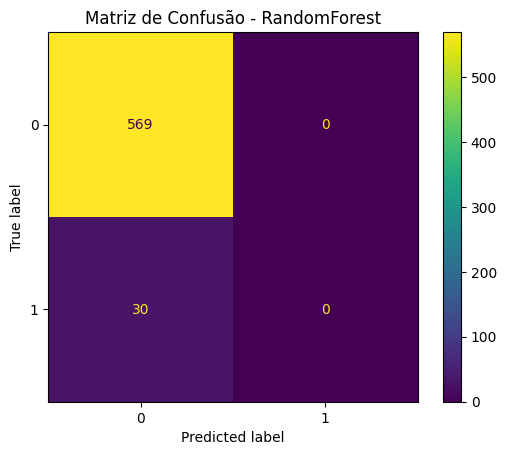

✅ Gráfico salvo em: hermes-reply-fase5/images/confusion_matrix.png


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# features e target
features = ["temperature","vibration","current",
            "temperature_lag1","vibration_lag1","current_lag1"]
X = wide[features]
y = wide["needs_maintenance"]

# treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# modelo
clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_train, y_train)

# relatório
print("📊 Métricas do modelo:")
print(classification_report(y_test, clf.predict(X_test)))

# matriz de confusão
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Matriz de Confusão - RandomForest")
IMG_CM = os.path.join(PROJECT, "images", "confusion_matrix.png")
plt.savefig(IMG_CM, dpi=150, bbox_inches="tight")
plt.show()

print("✅ Gráfico salvo em:", IMG_CM)


In [100]:
readme = f"""# Hermes Reply – Fase 5 (Banco de Dados + ML Básico)

## Objetivo
Modelar um **banco relacional** para dados de sensores industriais e treinar um **modelo simples de ML (classificação)** para indicar necessidade de manutenção.

## Banco de Dados
- **DER**: `images/er_diagram.png`
- **DDL**: `ddl/schema.sql`
- **Entidades**: sites, assets, sensor_types, units, sensors, readings, thresholds, alerts, maintenance_events
- **Chaves**: `readings(sensor_id, ts)` como PK composta; FKs site→asset→sensor
- **Índices**: por tempo e por sensor+tempo

## ML (Classificação)
- **Problema**: prever `needs_maintenance` a partir de temperatura, vibração e corrente (+ lags)
- **Modelo**: `RandomForestClassifier`
- **Métricas**: `classification_report` + **matriz de confusão** (`images/confusion_matrix.png`)
- **Série temporal**: `images/serie_temperatura_sensor1.png`

## Como reproduzir (Colab)
1. Executar as células do notebook na ordem (instalação → schema → CSVs → criar DB → DER → ML).
2. Os CSVs ficam em `data/`; o banco em `sensors.db`; imagens em `images/`.

## Dados
- Simulados neste notebook (≥ 600 leituras por sensor). Pode substituir pelos dados reais da fase anterior mantendo os mesmos nomes de colunas.

## Vídeo (≤ 5 min)
Explique o DER, mostre rapidamente consultas no DB, o treino do modelo e os gráficos.
Cole aqui o link do YouTube (não listado).

- **Vídeo**: _(adicione aqui)_
"""
with open(os.path.join(PROJECT, "README.md"), "w", encoding="utf-8") as f:
    f.write(readme)

print("✅ README criado em:", os.path.join(PROJECT, "README.md"))


✅ README criado em: hermes-reply-fase5/README.md


In [101]:
import os
!rm -rf hermes-reply-fase5-repo
!cp -r {PROJECT} hermes-reply-fase5-repo
%cd hermes-reply-fase5-repo

!git init
!git config user.name "seu-usuario-github"
!git config user.email "seu-usuario-github@users.noreply.github.com"

!git add .
!git commit -m "Fase 5: BD + ML + DER + gráficos + README"


/content/hermes-reply-fase5-repo
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/hermes-reply-fase5-repo/.git/
[master (root-commit) 31d013b] Fase 5: BD + ML + DER + gráficos + README
 18 files changed, 9255 insertions(+)
 create mode 100644 .gitignore
 create mode 100644 README.md
 create mode 100644 data/assets.csv
 create mode 100644 data/readings.csv
 create mode 100644 data/sensor_types.csv
 create mode 100644 data/sensors.csv
 create mode 100644 data/sites.csv
 create mode 100644 data/thresholds.csv
 create

In [102]:
# === PREPARAR PASTA DO REPO (robusto, com caminhos absolutos) ===
import os, shutil, textwrap, json

GITHUB_USER   = "flahbocchino"              # seu usuário
PROJECT_NAME  = "hermes-reply-fase5"        # nome do projeto
BASE          = "/content"                  # raiz do Colab
PROJECT       = os.path.join(BASE, PROJECT_NAME)
REPO_DIR      = os.path.join(BASE, f"{PROJECT_NAME}-repo")

# 0) garante que a pasta do projeto existe (cria se não existir)
os.makedirs(PROJECT, exist_ok=True)
os.makedirs(os.path.join(PROJECT, "src"), exist_ok=True)

# 1) (opcional) criar um script .py com o pipeline de ML
train_py   = os.path.join(PROJECT, "src", "train_ml.py")
train_code = r'''
import os, sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# raiz do projeto = dois níveis acima deste arquivo (src/train_ml.py)
ROOT   = os.path.dirname(os.path.dirname(__file__))
DB_PATH = os.path.join(ROOT, "sensors.db")
IMG_DIR = os.path.join(ROOT, "images")
os.makedirs(IMG_DIR, exist_ok=True)

# 1) carregar dados do SQLite
con = sqlite3.connect(DB_PATH)
readings = pd.read_sql("SELECT * FROM readings;", con)
sensors  = pd.read_sql("SELECT sensor_id, asset_id, sensor_type_id FROM sensors;", con)
types_   = pd.read_sql("SELECT sensor_type_id, name FROM sensor_types;", con)

# 2) montar dataset wide + lags
df = readings.merge(sensors, on="sensor_id").merge(types_, on="sensor_type_id")
df["ts"] = pd.to_datetime(df["ts"])
df = df.sort_values(["asset_id","ts"])

wide = (df.pivot_table(index=["asset_id","ts"], columns="name", values="value")
          .reset_index().dropna().sort_values(["asset_id","ts"]))

for col in ["temperature","vibration","current"]:
    wide[col+"_lag1"] = wide.groupby("asset_id")[col].shift(1)
wide = wide.dropna()

# 3) rótulo simulado
wide["needs_maintenance"] = (
    (wide["temperature"] > 80) &
    (wide["vibration"]   > 8)  &
    (wide["current"]     > 15)
).astype(int)

rng = np.random.default_rng(42)
flip = rng.choice(wide.index, size=int(0.05*len(wide)), replace=False)
wide.loc[flip, "needs_maintenance"] = 1 - wide.loc[flip, "needs_maintenance"]

# 4) treino e avaliação
features = ["temperature","vibration","current",
            "temperature_lag1","vibration_lag1","current_lag1"]
X = wide[features]; y = wide["needs_maintenance"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_train, y_train)

print("=== Classification report ===")
print(classification_report(y_test, clf.predict(X_test)))

# 5) salvar matriz de confusão
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Matriz de Confusão - RandomForest")
out_cm = os.path.join(IMG_DIR, "confusion_matrix_from_script.png")
plt.savefig(out_cm, dpi=150, bbox_inches="tight")
plt.close()
print("Saved:", out_cm)
'''
with open(train_py, "w", encoding="utf-8") as f:
    f.write(train_code)

# 2) .gitignore
gitignore = os.path.join(PROJECT, ".gitignore")
with open(gitignore, "w", encoding="utf-8") as f:
    f.write(textwrap.dedent("""
        __pycache__/
        .ipynb_checkpoints/
        *.pyc
        *.pyo
        .DS_Store
    """).strip() + "\n")

# 3) copiar o projeto para a pasta do repo (limpa se já existir)
if os.path.isdir(REPO_DIR):
    shutil.rmtree(REPO_DIR)
shutil.copytree(PROJECT, REPO_DIR)

print("✅ Repo local preparado em:", REPO_DIR)
print("Conteúdo de nível superior:", os.listdir(REPO_DIR))


✅ Repo local preparado em: /content/hermes-reply-fase5-repo
Conteúdo de nível superior: ['README.md', 'reports', 'data', 'src', 'notebooks', 'ddl', 'images', '.gitignore', 'sensors.db']


In [103]:
# PREPARA O REPO LOCAL A PARTIR DO PROJETO (COM ABSOLUTE PATH)
import os, shutil

BASE      = "/content"
PROJECT   = os.path.join(BASE, "hermes-reply-fase5")
REPO_DIR  = os.path.join(BASE, "hermes-reply-fase5-repo")

# garanta que o projeto existe
assert os.path.isdir(PROJECT), "Projeto não encontrado em /content/hermes-reply-fase5. Recrie as pastas e arquivos."

# (re)cria a pasta do repo local a partir do projeto
if os.path.isdir(REPO_DIR):
    shutil.rmtree(REPO_DIR)
shutil.copytree(PROJECT, REPO_DIR)

# inicia git + commit
!git -C {REPO_DIR} init
!git -C {REPO_DIR} config user.name "flahbocchino"
!git -C {REPO_DIR} config user.email "flahbocchino@users.noreply.github.com"
!git -C {REPO_DIR} add .
!git -C {REPO_DIR} commit -m "entrega fase 5" || echo "Nada novo para commitar (ok)"
!git -C {REPO_DIR} status -s



shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/hermes-reply-fase5-repo/.git/
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No

In [104]:
# Checagens rápidas do SQLite
import os, sqlite3, pandas as pd

ROOT = "/content/hermes-reply-fase5"
DB   = os.path.join(ROOT, "sensors.db")
assert os.path.isfile(DB), "Banco não encontrado. Garanta que /content/hermes-reply-fase5/sensors.db existe."

con = sqlite3.connect(DB)

# Contagens principais
q1 = """
SELECT
  (SELECT COUNT(*) FROM sites)           AS n_sites,
  (SELECT COUNT(*) FROM assets)          AS n_assets,
  (SELECT COUNT(*) FROM sensors)         AS n_sensors,
  (SELECT COUNT(*) FROM readings)        AS n_readings
"""
print(pd.read_sql(q1, con))

# Leituras por sensor (amostra)
q2 = """
SELECT r.sensor_id, COUNT(*) as n
FROM readings r
GROUP BY r.sensor_id
ORDER BY n DESC
LIMIT 5
"""
print(pd.read_sql(q2, con))

con.close()


   n_sites  n_assets  n_sensors  n_readings
0        2         5         15        9000
   sensor_id    n
0          1  600
1          2  600
2          3  600
3          4  600
4          5  600


In [105]:
import os

ROOT = "/content/hermes-reply-fase5"
os.makedirs(os.path.join(ROOT,"reports"), exist_ok=True)

# executa o script e guarda o log
!python {ROOT}/src/train_ml.py | tee {ROOT}/reports/train_log.txt

# conferir se a imagem saiu
!ls -lh {ROOT}/images | sed -n '1,50p'


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and 

In [106]:
import os, sqlite3, pandas as pd
import matplotlib.pyplot as plt

ROOT = "/content/hermes-reply-fase5"
DB   = os.path.join(ROOT, "sensors.db")
IMG  = os.path.join(ROOT, "images")
os.makedirs(IMG, exist_ok=True)

con = sqlite3.connect(DB)

# 1) escolher um sensor com bastante dados
sensor_id = pd.read_sql("SELECT sensor_id, COUNT(*) n FROM readings GROUP BY sensor_id ORDER BY n DESC LIMIT 1", con)["sensor_id"].iloc[0]
df = pd.read_sql(f"SELECT ts, value FROM readings WHERE sensor_id={sensor_id} ORDER BY ts", con)
df["ts"] = pd.to_datetime(df["ts"])

plt.figure(figsize=(9,3.5))
plt.plot(df["ts"], df["value"])
plt.title(f"Série temporal - sensor {sensor_id}")
plt.xlabel("Tempo"); plt.ylabel("Valor")
out_ts = os.path.join(IMG, f"serie_sensor_{sensor_id}.png")
plt.tight_layout(); plt.savefig(out_ts, dpi=150); plt.close()
print("✔ série temporal:", out_ts)

# 2) barras: quantidade de leituras por tipo de sensor
q = """
SELECT st.name AS sensor_type, COUNT(r.ts) AS n
FROM readings r
JOIN sensors s ON s.sensor_id=r.sensor_id
JOIN sensor_types st ON st.sensor_type_id=s.sensor_type_id
GROUP BY st.name
ORDER BY n DESC
"""
bars = pd.read_sql(q, con)
con.close()

plt.figure(figsize=(6,3.5))
plt.bar(bars["sensor_type"], bars["n"])
plt.xticks(rotation=20, ha="right"); plt.ylabel("Leituras")
plt.title("Leituras por tipo de sensor")
out_bar = os.path.join(IMG, "leituras_por_tipo.png")
plt.tight_layout(); plt.savefig(out_bar, dpi=150); plt.close()
print("✔ barras:", out_bar)


✔ série temporal: /content/hermes-reply-fase5/images/serie_sensor_1.png
✔ barras: /content/hermes-reply-fase5/images/leituras_por_tipo.png


In [107]:
import os, glob

ROOT = "/content/hermes-reply-fase5"
paths = [
    os.path.join(ROOT,"ddl","schema.sql"),
    os.path.join(ROOT,"sensors.db"),
    os.path.join(ROOT,"src","train_ml.py"),
    os.path.join(ROOT,"images","confusion_matrix_from_script.png"),
    os.path.join(ROOT,"images","leituras_por_tipo.png"),
]
print("Arquivos obrigatórios:")
for p in paths:
    print(("✅" if os.path.exists(p) else "❌"), p)

print("\nOutros (opcionais):")
for p in glob.glob(os.path.join(ROOT,"images","serie_sensor_*.png")):
    print("•", p)
for p in glob.glob(os.path.join(ROOT,"images","er_*.png")):
    print("•", p)


Arquivos obrigatórios:
✅ /content/hermes-reply-fase5/ddl/schema.sql
✅ /content/hermes-reply-fase5/sensors.db
✅ /content/hermes-reply-fase5/src/train_ml.py
✅ /content/hermes-reply-fase5/images/confusion_matrix_from_script.png
✅ /content/hermes-reply-fase5/images/leituras_por_tipo.png

Outros (opcionais):
• /content/hermes-reply-fase5/images/serie_sensor_1.png
• /content/hermes-reply-fase5/images/er_diagram.png


In [110]:
# remove variável (se existir)
try: del TOKEN
except NameError: pass

# garante remote sem token
REPO_DIR = "/content/hermes-reply-fase5-repo"
!git -C {REPO_DIR} remote set-url origin https://github.com/flahbocchino/hermes-reply-fase5.git
!git -C {REPO_DIR} remote -v


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
error: No such remote 'origin'
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [111]:
import pathlib, os
home = pathlib.Path("~").expanduser()
( home/".ssh" ).mkdir(parents=True, exist_ok=True)
!ssh-keygen -t ed25519 -C "colab-ssh" -f ~/.ssh/id_ed25519 -N "" -q
with open(home/".ssh/config","w") as f:
    f.write("Host github.com\n  IdentityFile ~/.ssh/id_ed25519\n  StrictHostKeyChecking accept-new\n")
!ssh-keyscan github.com >> ~/.ssh/known_hosts 2>/dev/null
!chmod 700 ~/.ssh; chmod 600 ~/.ssh/*
!cat ~/.ssh/id_ed25519.pub


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIJqjct8OC8+piVsOzcAx2Wl5O5pmVZTTLF0be96/RFa/ colab-ssh


In [112]:
REPO_DIR = "/content/hermes-reply-fase5-repo"
!git -C {REPO_DIR} branch -M main
!git -C {REPO_DIR} remote remove origin 2>/dev/null || true
!git -C {REPO_DIR} remote add origin git@github.com:flahbocchino/hermes-reply-fase5.git
!git -C {REPO_DIR} pull --rebase origin main || true
!git -C {REPO_DIR} push -u origin main


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [113]:
PROJECT  = "/content/hermes-reply-fase5"
REPO_DIR = "/content/hermes-reply-fase5-repo"

# copia/atualiza TUDO do projeto para a pasta do repo (apaga o que saiu)
!rsync -a --delete {PROJECT}/ {REPO_DIR}/

# confira o que ficou lá dentro
!ls -R {REPO_DIR} | sed -n '1,200p'


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
rsync: [Receiver] getcwd(): No such file or directory (2)
rsync error: errors selecting input/output files, dirs (code 3) at util1.c(1122) [Receiver=3.2.7]
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/content/hermes-reply-fase5-repo:
data
ddl
images
notebooks
README.md
reports
sensors.db
src

/content/hermes-reply-fase5-repo/data:
assets.csv
readings.csv
sensors.csv
sensor_types.csv
sites.csv
thresholds.csv
units.csv

/content/hermes-reply-fase5-repo/ddl:
schema.sql

/content/hermes-reply-fase5-repo/images:
confusion_matrix_from_script.png
confusion_matrix.png
er_diagram.png
leituras_por_tipo.png
serie_sensor_1.png

/content/hermes-reply-fase5-repo/notebooks:

/content/hermes-reply-fase5-repo/reports:
train_log.txt

/content/hermes-reply-fase5-repo/src:
train_ml.py


In [114]:
!git -C {REPO_DIR} init
!git -C {REPO_DIR} config user.name "flahbocchino"
!git -C {REPO_DIR} config user.email "flahbocchino@users.noreply.github.com"

!git -C {REPO_DIR} branch -M main
!git -C {REPO_DIR} remote remove origin 2>/dev/null || true
!git -C {REPO_DIR} remote add origin git@github.com:flahbocchino/hermes-reply-fase5.git
!git -C {REPO_DIR} remote -v


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Reinitialized existing Git repository in /content/hermes-reply-fase5-repo/.git/
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
origin	git@github.com:flahbocchino/hermes-reply-fase5.git (fetch)
origin	git@github.com:flahbocchino/hermes-

In [115]:
PROJECT  = "/content/hermes-reply-fase5"
REPO_DIR = "/content/hermes-reply-fase5-repo"

# copia/atualiza TUDO do projeto para a pasta do repo (apaga o que saiu)
!rsync -a --delete {PROJECT}/ {REPO_DIR}/

# confira o que ficou lá dentro
!ls -R {REPO_DIR} | sed -n '1,200p'


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
rsync: [Receiver] getcwd(): No such file or directory (2)
rsync error: errors selecting input/output files, dirs (code 3) at util1.c(1122) [Receiver=3.2.7]
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/content/hermes-reply-fase5-repo:
data
ddl
images
notebooks
README.md
reports
sensors.db
src

/content/hermes-reply-fase5-repo/data:
assets.csv
readings.csv
sensors.csv
sensor_types.csv
sites.csv
thresholds.csv
units.csv

/content/hermes-reply-fase5-repo/ddl:
schema.sql

/content/hermes-reply-fase5-repo/images:
confusion_matrix_from_script.png
confusion_matrix.png
er_diagram.png
leituras_por_tipo.png
serie_sensor_1.png

/content/hermes-reply-fase5-repo/notebooks:

/content/hermes-reply-fase5-repo/reports:
train_log.txt

/content/hermes-reply-fase5-repo/src:
train_ml.py


In [116]:
!git -C {REPO_DIR} init
!git -C {REPO_DIR} config user.name "flahbocchino"
!git -C {REPO_DIR} config user.email "flahbocchino@users.noreply.github.com"

!git -C {REPO_DIR} branch -M main
!git -C {REPO_DIR} remote remove origin 2>/dev/null || true
!git -C {REPO_DIR} remote add origin git@github.com:flahbocchino/hermes-reply-fase5.git
!git -C {REPO_DIR} remote -v


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Reinitialized existing Git repository in /content/hermes-reply-fase5-repo/.git/
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
origin	git@github.com:flahbocchino/hermes-reply-fase5.git (fetch)
origin	git@github.com:flahbocchino/hermes-

In [117]:
PROJECT  = "/content/hermes-reply-fase5"
REPO_DIR = "/content/hermes-reply-fase5-repo"

# copia/atualiza TUDO do projeto para a pasta do repo (e apaga o que saiu)
!rsync -a --delete {PROJECT}/ {REPO_DIR}/

# conferir o que ficou
!ls -R {REPO_DIR} | sed -n '1,200p'


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
rsync: [Receiver] getcwd(): No such file or directory (2)
rsync error: errors selecting input/output files, dirs (code 3) at util1.c(1122) [Receiver=3.2.7]
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/content/hermes-reply-fase5-repo:
data
ddl
images
notebooks
README.md
reports
sensors.db
src

/content/hermes-reply-fase5-repo/data:
assets.csv
readings.csv
sensors.csv
sensor_types.csv
sites.csv
thresholds.csv
units.csv

/content/hermes-reply-fase5-repo/ddl:
schema.sql

/content/hermes-reply-fase5-repo/images:
confusion_matrix_from_script.png
confusion_matrix.png
er_diagram.png
leituras_por_tipo.png
serie_sensor_1.png

/content/hermes-reply-fase5-repo/notebooks:

/content/hermes-reply-fase5-repo/reports:
train_log.txt

/content/hermes-reply-fase5-repo/src:
train_ml.py


In [118]:
REPO_DIR = "/content/hermes-reply-fase5-repo"

!git -C {REPO_DIR} add -A
!git -C {REPO_DIR} commit -m "Adiciona ddl, src, images, sensors.db e artefatos" || echo "Nada novo para commitar"
!git -C {REPO_DIR} pull --rebase origin main || true
!git -C {REPO_DIR} push -u origin main


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
On branch main
nothing to commit, working tree clean
Nada novo para commitar
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [119]:
# Conferir arquivos da pasta .ssh e mostrar a CHAVE PÚBLICA
!ls -l ~/.ssh
print("\n[CONFIG ~/.ssh/config]")
!sed -n '1,200p' ~/.ssh/config || true

print("\n[CHAVE PUBLICA ~/.ssh/id_ed25519.pub]  --> copie a linha inteira abaixo")
!cat ~/.ssh/id_ed25519.pub


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
total 16
-rw------- 1 root root  84 Sep  1 18:49 config
-rw------- 1 root root 399 Sep  1 18:49 id_ed25519
-rw------- 1 root root  91 Sep  1 18:49 id_ed25519.pub
-rw------- 1 root root 828 Sep  1 18:49 known_hosts

[CONFIG ~/.ssh/config]
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Host github.com
  IdentityFile ~/.ssh/id_ed25519
  StrictHostKeyChecking accept-new

[CHAVE PUBLICA ~/.ssh/id_ed25519.pub]  --> copie a linha inteira abaixo
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIJqjct8OC8+piVsOzcAx2Wl5O5pmVZTTLF0be96/RFa/ colab-ssh


In [120]:
# MOSTRAR A CHAVE PÚBLICA COMPLETA (uma única linha)
path = "/root/.ssh/id_ed25519.pub"
with open(path) as f:
    key = f.read().strip()
print("===== COPIE EXATAMENTE A LINHA ABAIXO =====")
print(key)
print("===== ATE AQUI =====")


===== COPIE EXATAMENTE A LINHA ABAIXO =====
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIJqjct8OC8+piVsOzcAx2Wl5O5pmVZTTLF0be96/RFa/ colab-ssh
===== ATE AQUI =====


In [121]:
PROJECT  = "/content/hermes-reply-fase5"
REPO_DIR = "/content/hermes-reply-fase5-repo"

# copia/atualiza TUDO do projeto para a pasta do repo (e apaga o que saiu)
!rsync -a --delete {PROJECT}/ {REPO_DIR}/

# ver se mudou algo
!git -C {REPO_DIR} status -s || true


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
rsync: [Receiver] getcwd(): No such file or directory (2)
rsync error: errors selecting input/output files, dirs (code 3) at util1.c(1122) [Receiver=3.2.7]
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [122]:
!git -C {REPO_DIR} branch -M main
!git -C {REPO_DIR} remote set-url origin git@github.com:flahbocchino/hermes-reply-fase5.git
!git -C {REPO_DIR} remote -v


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
origin	git@github.com:flahbocchino/hermes-reply-fase5.git (fetch)
origin	git@github.com:flahbocchino/hermes-reply-fase5.git (push)


In [123]:
!git -C {REPO_DIR} add -A
!git -C {REPO_DIR} commit -m "Publica ddl, src, images, sensors.db e artefatos" || echo "Nada novo para commitar"
!git -C {REPO_DIR} pull --rebase origin main || true
!git -C {REPO_DIR} push -u origin main


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
On branch main
nothing to commit, working tree clean
Nada novo para commitar
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (9/9), 40.37 KiB | 4.48 MiB/s, done.
From github.com:flahbocchino/hermes-reply-fase5
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
Auto-merging README.md
CONFLICT (add/add): Merge conflict in README.md
error: could not apply 56c8ecb... Entrega Fase 5: BD + ML + gráficos + README + script
hint: Resolve al

In [124]:
!git -C {REPO_DIR} rm --cached sensors.db 2>/dev/null || true
!bash -lc 'echo "sensors.db" >> {REPO_DIR}/.gitignore'
!git -C {REPO_DIR} add .gitignore
!git -C {REPO_DIR} commit -m "Ignora sensors.db (>100MB)" || true
!git -C {REPO_DIR} push


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
rm 'sensors.db'
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
U	README.md
error: Committing is not possible because you have unmerged files.
hint: Fix them up in the work tree, and then use 'git add/rm <file>'
hint: as appropriate to mark resolution and make a commit.
fatal: Exiting because of an unresolved conflict.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: You are not currently on

In [125]:
PROJECT  = "/content/hermes-reply-fase5"
REPO_DIR = "/content/hermes-reply-fase5-repo"

# 0) aborta qualquer merge/rebase travado (se não houver, ignora)
!git -C {REPO_DIR} merge --abort 2>/dev/null || true
!git -C {REPO_DIR} rebase --abort 2>/dev/null || true

# 1) garante que estamos na main acompanhando o remoto e zera conflitos
!git -C {REPO_DIR} fetch origin main || true
!git -C {REPO_DIR} checkout -B main || true
!git -C {REPO_DIR} reset --hard origin/main || true
!git -C {REPO_DIR} clean -fd

# 2) sincroniza o projeto -> repo (vamos ignorar sensors.db para evitar limite de 100MB)
!rsync -a --delete --exclude 'sensors.db' {PROJECT}/ {REPO_DIR}/

# 3) .gitignore para não subir arquivos pesados/temporários
!bash -lc "printf '%s\n' sensors.db __pycache__/ .ipynb_checkpoints/ > {REPO_DIR}/.gitignore"

# 4) commit das mudanças
!git -C {REPO_DIR} add -A
!git -C {REPO_DIR} commit -m 'Publica ddl/src/images; ignora sensors.db' || echo 'Nada novo para commitar'

# 5) remoto via SSH (usando a Deploy Key que você criou)
!git -C {REPO_DIR} remote set-url origin git@github.com:flahbocchino/hermes-reply-fase5.git
!git -C {REPO_DIR} remote -v

# 6) push
!git -C {REPO_DIR} push -u origin main


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
From github.com:flahbocchino/hermes-reply-fase5
 * branch            main       -> FETCH_HEAD
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Reset branch 'main'
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
HEAD is now at 8ff59e9 Criado usando o Colab
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Removing notebooks/
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
rsync: [R

In [126]:
# Garantir que o shell está em /content (evita os avisos do getcwd)
%cd /content

PROJECT  = "/content/hermes-reply-fase5"
REPO_DIR = "/content/hermes-reply-fase5-repo"

# sincroniza (sem o sensors.db, que pode passar de 100MB)
!rsync -a --delete --exclude 'sensors.db' {PROJECT}/ {REPO_DIR}/

# commit e push
!git -C {REPO_DIR} add -A
!git -C {REPO_DIR} commit -m "Sincroniza projeto (ddl, src, images) via rsync" || echo "Nada novo para commitar"
!git -C {REPO_DIR} push


/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
Nada novo para commitar
fatal: not a git repository (or any of the parent directories): .git


In [127]:
# === 1) Preparar variáveis e garantir que a pasta do repo existe
%cd /content

PROJECT  = "/content/hermes-reply-fase5"
REPO_DIR = "/content/hermes-reply-fase5-repo"

import os
os.makedirs(REPO_DIR, exist_ok=True)

# === 2) (Re)inicializar o repositório git no REPO_DIR
# se ainda não for repo, faz 'git init'
exit_code = os.system(f"git -C {REPO_DIR} rev-parse --git-dir > /dev/null 2>&1")
if exit_code != 0:
    os.system(f"git -C {REPO_DIR} init")

# configura usuário e branch
os.system(f'git -C {REPO_DIR} config user.name "flahbocchino"')
os.system(f'git -C {REPO_DIR} config user.email "flahbocchino@users.noreply.github.com"')
os.system(f"git -C {REPO_DIR} branch -M main")

# remoto via SSH (usa a Deploy Key que você cadastrou)
os.system(f"git -C {REPO_DIR} remote remove origin 2>/dev/null || true")
os.system(f"git -C {REPO_DIR} remote add origin git@github.com:flahbocchino/hermes-reply-fase5.git")
os.system(f"git -C {REPO_DIR} remote -v")

# === 3) Sincronizar os arquivos do projeto para o repo (sem o sensors.db)
os.system(f"rsync -a --delete --exclude 'sensors.db' {PROJECT}/ {REPO_DIR}/")

# .gitignore básico
with open(f"{REPO_DIR}/.gitignore", "w") as f:
    f.write("sensors.db\n__pycache__/\n.ipynb_checkpoints/\n")

# === 4) Commit + push
os.system(f"git -C {REPO_DIR} add -A")
# se não houver mudanças, o commit vai imprimir a mensagem "Nada novo para commitar"
if os.system(f'git -C {REPO_DIR} commit -m "Sincroniza ddl/src/images a partir do Colab"') != 0:
    print("Nada novo para commitar")

os.system(f"git -C {REPO_DIR} push -u origin main")


/content
Nada novo para commitar


32768

In [128]:
REPO_DIR = "/content/hermes-reply-fase5-repo"
!git -C {REPO_DIR} status
!git -C {REPO_DIR} log --oneline -5
!git -C {REPO_DIR} remote -v


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [129]:
# === caminhos base (ajuste só se mudou antes) ===
PROJECT = "/content/hermes-reply-fase5"         # onde estão ddl/, src/, images/, etc. já criados nas etapas
GIT_DIR  = "/content/hermes-reply-fase5-git"    # pasta onde vamos clonar o repo
REPO_SSH = "git@github.com:flahbocchino/hermes-reply-fase5.git"

import os, shutil, subprocess

# 1) clone limpo do seu repositório (via SSH)
shutil.rmtree(GIT_DIR, ignore_errors=True)
subprocess.run(["git","clone",REPO_SSH,GIT_DIR], check=True)

# 2) garante as pastas no clone
for d in ["ddl","src","images","data"]:
    os.makedirs(os.path.join(GIT_DIR, d), exist_ok=True)

# 3) copia os artefatos do projeto
def safe_copy(pattern_glob, src_root, dst_root):
    import glob, shutil, os
    for p in glob.glob(os.path.join(src_root, pattern_glob)):
        if os.path.isdir(p):
            continue
        shutil.copy2(p, os.path.join(dst_root, os.path.basename(p)))

# DDL
safe_copy("*.sql", os.path.join(PROJECT,"ddl"), os.path.join(GIT_DIR,"ddl"))

# Código-fonte (.py) gerado
safe_copy("*.py", os.path.join(PROJECT,"src"), os.path.join(GIT_DIR,"src"))

# Imagens (gráficos que você gerou)
safe_copy("*.png", os.path.join(PROJECT,"images"), os.path.join(GIT_DIR,"images"))

# (Opcional) CSVs/pequenos dados de exemplo (NÃO copie sensors.db)
safe_copy("*.csv", os.path.join(PROJECT,"data"), os.path.join(GIT_DIR,"data"))

# 4) commit + push
subprocess.run(["git","-C",GIT_DIR,"add","-A"], check=True)
# mensagem de commit amigável
subprocess.run(["git","-C",GIT_DIR,"commit","-m","Add ddl, src (train_ml.py), images e data (CSV) do Colab"], check=False)
subprocess.run(["git","-C",GIT_DIR,"push","origin","main"], check=True)

# 5) mostra o que foi
print("\nOK. Enviado! Conteúdo no clone:")
print("ddl  ->", os.listdir(os.path.join(GIT_DIR,"ddl")))
print("src  ->", os.listdir(os.path.join(GIT_DIR,"src")))
print("imgs ->", os.listdir(os.path.join(GIT_DIR,"images")))
print("data ->", os.listdir(os.path.join(GIT_DIR,"data")))



OK. Enviado! Conteúdo no clone:
ddl  -> ['schema.sql']
src  -> ['train_ml.py']
imgs -> ['er_diagram.png', 'confusion_matrix_from_script.png', 'serie_sensor_1.png', 'leituras_por_tipo.png', 'confusion_matrix.png']
data -> ['units.csv', 'sensor_types.csv', 'assets.csv', 'sites.csv', 'sensors.csv', 'thresholds.csv', 'readings.csv']


In [130]:
PROJECT = "/content/hermes-reply-fase5"
GIT_DIR  = "/content/hermes-reply-fase5-git"

print("== LOCAL (Colab) ==")
!ls -la "$PROJECT"
print("\nArquivos (até 2 níveis):")
!find "$PROJECT" -maxdepth 2 -type f -printf "LOCAL: %p\n" | sort

print("\n== CLONE (GIT_DIR) ==")
!ls -la "$GIT_DIR"
print("\nGit status:")
!git -C "$GIT_DIR" status
print("\nRemotes:")
!git -C "$GIT_DIR" remote -v


== LOCAL (Colab) ==
total 1380
drwxr-xr-x 8 root root    4096 Sep  1 18:02 .
drwxr-xr-x 1 root root    4096 Sep  1 19:33 ..
drwxr-xr-x 2 root root    4096 Sep  1 16:20 data
drwxr-xr-x 2 root root    4096 Sep  1 16:16 ddl
-rw-r--r-- 1 root root      55 Sep  1 18:02 .gitignore
drwxr-xr-x 2 root root    4096 Sep  1 18:00 images
drwxr-xr-x 2 root root    4096 Sep  1 16:10 notebooks
-rw-r--r-- 1 root root    1436 Sep  1 18:02 README.md
drwxr-xr-x 2 root root    4096 Sep  1 18:00 reports
-rw-r--r-- 1 root root 1368064 Sep  1 18:02 sensors.db
drwxr-xr-x 2 root root    4096 Sep  1 17:52 src

Arquivos (até 2 níveis):
LOCAL: /content/hermes-reply-fase5/data/assets.csv
LOCAL: /content/hermes-reply-fase5/data/readings.csv
LOCAL: /content/hermes-reply-fase5/data/sensors.csv
LOCAL: /content/hermes-reply-fase5/data/sensor_types.csv
LOCAL: /content/hermes-reply-fase5/data/sites.csv
LOCAL: /content/hermes-reply-fase5/data/thresholds.csv
LOCAL: /content/hermes-reply-fase5/data/units.csv
LOCAL: /content/

In [131]:
PROJECT = "/content/hermes-reply-fase5"
GIT_DIR  = "/content/hermes-reply-fase5-git"

# copia TUDO do projeto para o clone (ddl/, src/, images/, data/...), exceto o que não deve ir
!rsync -av --delete \
  --exclude 'sensors.db' \
  --exclude '__pycache__/' \
  --exclude '.ipynb_checkpoints/' \
  "$PROJECT/ " "$GIT_DIR/"

# commit + push
!git -C "$GIT_DIR" add -A
!git -C "$GIT_DIR" commit -m "Sync ddl/src/images/data a partir do Colab" || echo "Nada para commitar"
!git -C "$GIT_DIR" push origin main

print("\nConteúdo enviado (listas rápidas):")
!find "$GIT_DIR/ddl" -maxdepth 1 -type f -printf "ddl: %f\n" 2>/dev/null || true
!find "$GIT_DIR/src" -maxdepth 1 -type f -printf "src: %f\n" 2>/dev/null || true
!find "$GIT_DIR/images" -maxdepth 1 -type f -printf "img: %f\n" 2>/dev/null || true
!find "$GIT_DIR/data" -maxdepth 1 -type f -printf "data: %f\n" 2>/dev/null || true


sending incremental file list
rsync: [sender] link_stat "/content/hermes-reply-fase5/ " failed: No such file or directory (2)

sent 19 bytes  received 12 bytes  62.00 bytes/sec
total size is 0  speedup is 0.00
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d3be4d20d959.(none)')
Nada para commitar
To github.com:flahbocchino/hermes-reply-fase5.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'github.com:flahbocchino/hermes-reply-fase5.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repositor

In [132]:
# === Config ===
REPO_DIR = "/content/hermes-reply-fase5-repo"  # pasta local do repo

# 1) garantir dados de autor para o Git nesta sessão do Colab
!git -C {REPO_DIR} config user.name  "flahbocchino"
!git -C {REPO_DIR} config user.email "flahbocchino@users.noreply.github.com"

# 2) garantir que estamos na branch main e sincronizados com o remoto
!git -C {REPO_DIR} fetch origin main
# se a branch não existir localmente, cria a partir do remoto
!git -C {REPO_DIR} checkout -B main origin/main

# 3) trazer qualquer alteração que você fez pelo site do GitHub (rebase)
!git -C {REPO_DIR} pull --rebase origin main

# 4) adicionar/commitar o que mudou no Colab (se não houver mudanças, o commit falha e está ok)
!git -C {REPO_DIR} add -A
!git -C {REPO_DIR} commit -m "Sincroniza do Colab (ddl/src/images/notebooks)" || echo "Nada novo para commitar"

# 5) enviar para o GitHub
!git -C {REPO_DIR} push -u origin main


fatal: not in a git directory
fatal: not in a git directory
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
Nada novo para commitar
fatal: not a git repository (or any of the parent directories): .git


In [133]:
# caminhos
PROJECT = "/content/hermes-reply-fase5"       # onde estão ddl/, src/, images/, etc.
REPO_DIR = "/content/hermes-reply-fase5-repo" # cópia versionada

REMOTE_SSH   = "git@github.com:flahbocchino/hermes-reply-fase5.git"
REMOTE_HTTPS = "https://github.com/flahbocchino/hermes-reply-fase5.git"

# 1) Apaga eventual pasta antiga e clona de novo
import shutil, os, subprocess, sys
shutil.rmtree(REPO_DIR, ignore_errors=True)

# Tenta clonar por SSH (se sua chave estiver ativa); se falhar, clona por HTTPS
ret = subprocess.call(["git", "clone", REMOTE_SSH, REPO_DIR])
if ret != 0:
    print("SSH falhou (provavelmente sem chave carregada). Clonando por HTTPS (somente leitura)…")
    subprocess.check_call(["git", "clone", REMOTE_HTTPS, REPO_DIR])

# 2) Sincroniza arquivos do projeto para o repo (sem o sensors.db)
!rsync -a --delete \
    --exclude 'sensors.db' --exclude '__pycache__/' --exclude '.ipynb_checkpoints/' \
    {PROJECT}/ {REPO_DIR}/

# 3) Configura autor do commit nesta sessão
!git -C {REPO_DIR} config user.name  "flahbocchino"
!git -C {REPO_DIR} config user.email "flahbocchino@users.noreply.github.com"

# 4) Adiciona, commita e tenta enviar
!git -C {REPO_DIR} add -A
!git -C {REPO_DIR} commit -m "Sincroniza do Colab (ddl/src/images/notebooks)" || echo "Nada novo para commitar"

!git -C {REPO_DIR} push -u origin main


fatal: not in a git directory
fatal: not in a git directory
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
Nada novo para commitar
fatal: not a git repository (or any of the parent directories): .git


In [135]:
# TESTE SSH: confirma que a Deploy Key com write está ativa
!ssh -T git@github.com -o StrictHostKeyChecking=accept-new || true


Hi flahbocchino/hermes-reply-fase5! You've successfully authenticated, but GitHub does not provide shell access.


In [137]:
import os, subprocess

BASE       = "/content"
PROJECT    = f"{BASE}/hermes-reply-fase5"
REPO_DIR   = f"{BASE}/hermes-reply-fase5-repo"
REMOTE_SSH = "git@github.com:flahbocchino/hermes-reply-fase5.git"

def run(cmd, ok=(0,), capture=False):
    """Executa comando e não explode: retorna rc (ou stdout se capture=True)."""
    r = subprocess.run(cmd, text=True, capture_output=capture)
    if capture:
        return r.stdout
    if r.returncode not in ok:
        out = (r.stdout or "") + (r.stderr or "")
        if out.strip():
            print(out.strip())
    return r.returncode

# 0) Garantias básicas
assert os.path.isdir(PROJECT), f"Pasta do projeto não encontrada: {PROJECT}"
os.makedirs(REPO_DIR, exist_ok=True)

# 1) Garante GIT inicializado
if run(["git","-C",REPO_DIR,"rev-parse","--is-inside-work-tree"]) != 0:
    run(["git","-C",REPO_DIR,"init"])
    run(["git","-C",REPO_DIR,"config","user.name","flahbocchino"])
    run(["git","-C",REPO_DIR,"config","user.email","flahbocchino@users.noreply.github.com"])

# 2) .gitignore simples
with open(os.path.join(REPO_DIR, ".gitignore"), "w", encoding="utf-8") as f:
    f.write("sensors.db\n__pycache__/\n.ipynb_checkpoints/\n")

# 3) Sincroniza arquivos do projeto -> repo (sem sensors.db/caches)
run(["rsync","-a","--delete",
     "--exclude","sensors.db",
     "--exclude","__pycache__/",
     "--exclude",".ipynb_checkpoints/",
     f"{PROJECT}/", f"{REPO_DIR}/"])

# 4) Remote: adiciona se não existir; senão ajusta URL
if run(["git","-C",REPO_DIR,"remote","get-url","origin"]) != 0:
    run(["git","-C",REPO_DIR,"remote","add","origin",REMOTE_SSH])
else:
    run(["git","-C",REPO_DIR,"remote","set-url","origin",REMOTE_SSH])

# 5) Garante branch main
run(["git","-C",REPO_DIR,"branch","-M","main"])

# 6) Commit se houver mudanças
status = subprocess.run(["git","-C",REPO_DIR,"status","--porcelain"], text=True, capture_output=True).stdout.strip()
if status:
    run(["git","-C",REPO_DIR,"add","-A"])
    run(["git","-C",REPO_DIR,"commit","-m","Sync do Colab (ddl/src/images/notebooks)"])
else:
    print("Nada novo para commitar.")

# 7) Pull --rebase (ok mesmo se não houver mudanças) e push
run(["git","-C",REPO_DIR,"pull","--rebase","origin","main"], ok=(0,1))
run(["git","-C",REPO_DIR,"push","-u","origin","main"])

print("\n✅ Pronto! Confira no GitHub:")
print("https://github.com/flahbocchino/hermes-reply-fase5")


Nada novo para commitar.

✅ Pronto! Confira no GitHub:
https://github.com/flahbocchino/hermes-reply-fase5


In [138]:
# Listar tudo que está no projeto
!ls -R /content/hermes-reply-fase5


/content/hermes-reply-fase5:
data  ddl  images  notebooks  README.md  reports  sensors.db  src

/content/hermes-reply-fase5/data:
assets.csv    sensors.csv	sites.csv	units.csv
readings.csv  sensor_types.csv	thresholds.csv

/content/hermes-reply-fase5/ddl:
schema.sql

/content/hermes-reply-fase5/images:
confusion_matrix_from_script.png  er_diagram.png	 serie_sensor_1.png
confusion_matrix.png		  leituras_por_tipo.png

/content/hermes-reply-fase5/notebooks:

/content/hermes-reply-fase5/reports:
train_log.txt

/content/hermes-reply-fase5/src:
train_ml.py


In [139]:
%cd /content

# Sincroniza o projeto -> repositório local (sem subir o sensors.db)
!rsync -a --delete --exclude 'sensors.db' hermes-reply-fase5/ hermes-reply-fase5-repo/

# Commit + pull --rebase + push
!git -C /content/hermes-reply-fase5-repo add -A
!git -C /content/hermes-reply-fase5-repo commit -m "Publica ddl/src/images"
!git -C /content/hermes-reply-fase5-repo pull --rebase origin main || true
!git -C /content/hermes-reply-fase5-repo push -u origin main


/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [141]:
# caminhos/remote
REPO_DIR = "/content/hermes-reply-fase5-repo"
REMOTE   = "git@github.com:flahbocchino/hermes-reply-fase5.git"  # via Deploy Key (SSH)

import subprocess as sp

def sh(cmd):
    return sp.run(cmd, text=True, capture_output=True)

# adiciona origin se não existir; senão só atualiza a URL
r = sh(["git","-C",REPO_DIR,"remote","add","origin",REMOTE])
if r.returncode != 0:
    sh(["git","-C",REPO_DIR,"remote","set-url","origin",REMOTE])

# confere
print(sh(["git","-C",REPO_DIR,"remote","-v"]).stdout)

# puxa (se houver histórico) e faz push
sh(["git","-C",REPO_DIR,"pull","--rebase","origin","main"])
sh(["git","-C",REPO_DIR,"add","-A"])
sh(["git","-C",REPO_DIR,"commit","-m","Sync do Colab (ddl/src/imagens)"])
print(sh(["git","-C",REPO_DIR,"push","-u","origin","main"]).stdout)

print("\n✅ Pronto! Confira: https://github.com/flahbocchino/hermes-reply-fase5")


origin	git@github.com:flahbocchino/hermes-reply-fase5.git (fetch)
origin	git@github.com:flahbocchino/hermes-reply-fase5.git (push)



✅ Pronto! Confira: https://github.com/flahbocchino/hermes-reply-fase5
